## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = r'C:\Users\Gio\Documents\UCLA\ece 147\HW2-code\cifar-10-batches-py'# You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [4]:
from nndl import Softmax

In [5]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [9]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [10]:
print(loss)

2.3067442140523253


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

This makes sense since you have 1 in 10 chances of choosing the correct class. By calculating the -log( 1/10) = 2.3 

#### Softmax gradient

In [16]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: 2.755788 analytic: 2.755788, relative error: 2.732382e-08
numerical: -0.081415 analytic: -0.081415, relative error: 8.151462e-07
numerical: -0.742626 analytic: -0.742626, relative error: 1.075228e-08
numerical: -1.054124 analytic: -1.054124, relative error: 1.928638e-08
numerical: 0.542858 analytic: 0.542858, relative error: 3.312905e-08
numerical: 2.118830 analytic: 2.118830, relative error: 1.113419e-08
numerical: -0.220434 analytic: -0.220434, relative error: 2.001819e-08
numerical: 3.773366 analytic: 3.773366, relative error: 4.207222e-09
numerical: -0.632775 analytic: -0.632775, relative error: 1.611297e-08
numerical: -1.727569 analytic: -1.727569, relative error: 5.172478e-09


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [18]:
import time

In [19]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3229195323925738 / 316.5371055981419 computed in 0.9284665584564209s
Vectorized loss / grad: 2.322919532392573 / 316.5371055981419 computed in 0.039861440658569336s
difference in loss / grad: 8.881784197001252e-16 /2.379924072214256e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:



iteration 0 / 1500: loss 2.3992688518170064
iteration 100 / 1500: loss 2.0292143925261965
iteration 200 / 1500: loss 1.9914666215435983
iteration 300 / 1500: loss 1.863759278921616
iteration 400 / 1500: loss 2.0309943672953246
iteration 500 / 1500: loss 1.8195804564031284
iteration 600 / 1500: loss 1.9245985780263026
iteration 700 / 1500: loss 1.8435717978352413
iteration 800 / 1500: loss 1.7552818805775632
iteration 900 / 1500: loss 2.0078233702819457
iteration 1000 / 1500: loss 1.828834570888
iteration 1100 / 1500: loss 1.8793480328163452
iteration 1200 / 1500: loss 1.7830758874883081
iteration 1300 / 1500: loss 1.783208716250437
iteration 1400 / 1500: loss 1.817120651587013
That took 14.920446395874023s


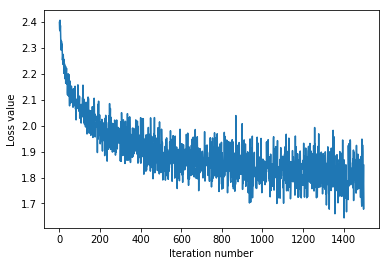

In [26]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [27]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.38195918367346937
validation accuracy: 0.384


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [11]:
np.finfo(float).eps

2.220446049250313e-16

In [15]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
learn_rates = [1e-5,1e-6,1e-8]
best_learn = 0
best_val = float(0)
for l in learn_rates:
    
    loss_hist2 = softmax.train(X_train, y_train, learning_rate=l,
                      num_iters=1500, verbose=False)
    y_train_pred2 = softmax.predict(X_train)
    accuracy_train = np.sum(y_train_pred2==y_train) / y_train.shape[0]
    
    
    y_val_pred2 = softmax.predict(X_val)
    accuracy_val = np.sum(y_val_pred2 ==y_val)/ y_val.shape[0]
    print('train accuracy: {} val accuracy: {}'.format(accuracy_train,accuracy_val))
   
        
    if accuracy_val > best_val:
        best_val = accuracy_val
        best_learn = l
    
print('Best validation: {}'.format(best_val))
print('Best Learn Rate: {}'.format(best_learn))
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


train accuracy: 0.28720408163265304 val accuracy: 0.282
train accuracy: 0.4173061224489796 val accuracy: 0.402
train accuracy: 0.2933061224489796 val accuracy: 0.314
Best validation: 0.402
Best Learn Rate: 1e-06
